## Imports  

In [15]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer 
import torch
import pandas as pd
from datasets import Dataset
import seaborn as sns       

In [16]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_tensor="pt")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

id2label = {0: "CONTROL", 1: "BROCA"}
label2id = {"CONTROL": 0, "BROCA": 1}

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# dataset_filename = "../../preprocessing/data/processed_merge.csv"
dataset_filename = "../../linguistic_model/data/synthetic_clan_train.csv"
data = pd.read_csv(dataset_filename, encoding='utf8', index_col=False)#.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

In [19]:
data.head()

,modified,label
0,maybe the dog was trying to escape out of this...,0
1,there is no reason to watch it.,0
2,"thankfully, she vanishes, having brought nothi...",0
3,i thought it was a black ferris bueller days off.,0
4,"all, kim basingers?",1


In [20]:
len(data)

49850

In [21]:
# check if there is the same data imbalance ratio
data["label"].value_counts()

label
0    35908
1    13942
Name: count, dtype: int64

In [22]:
dataset = Dataset.from_pandas(data)

In [23]:
dataset

Dataset({
    features: ['modified', 'label'],
    num_rows: 49850
})

In [24]:
def compute_metrics(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    metric_res={}
    for met in metrics:
       metric_res[met]=metric[met].compute(predictions=predictions, references=labels)[met]
    print(metric_res)
    return metric_res

In [25]:
def preprocess_function(examples):
    return tokenizer(examples["modified"], padding=True, truncation=True, return_tensors="pt")

In [26]:
tokenized_data = dataset.map(preprocess_function, batched=True).with_format("torch")

Map:   0%|          | 0/49850 [00:00<?, ? examples/s]

In [27]:
tokenized_data_split = tokenized_data.train_test_split(test_size=0.2, seed=42)

In [28]:
tokenized_data_split['test']['label']

tensor([0, 1, 0,  ..., 0, 0, 0])

In [29]:
training_args = TrainingArguments(
    output_dir="../models/bert_classifier_reverse",
    learning_rate=2e-5,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    use_cpu = False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data_split["train"],
    eval_dataset=tokenized_data_split["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model('../models/bert_finetuned_reverse')

C:\Users\imruh\miniconda3\envs\thesis\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss


{'accuracy': 0.9630892678034102, 'recall': 0.9744861800141743, 'precision': 0.9028233749179252, 'f1': 0.9372869802317655}
{'accuracy': 0.9673019057171515, 'recall': 0.9574769666902906, 'precision': 0.9291609353507565, 'f1': 0.9431064572425829}


In [30]:
trainer.evaluate()

{'accuracy': 0.9630892678034102, 'recall': 0.9744861800141743, 'precision': 0.9028233749179252, 'f1': 0.9372869802317655}


{'eval_loss': 0.10301639884710312,
 'eval_accuracy': 0.9630892678034102,
 'eval_recall': 0.9744861800141743,
 'eval_precision': 0.9028233749179252,
 'eval_f1': 0.9372869802317655,
 'eval_runtime': 41.5382,
 'eval_samples_per_second': 240.02,
 'eval_steps_per_second': 10.015,
 'epoch': 2.0}

# Evaluate model

In [31]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned_reverse", return_tensor="pt")
model = AutoModelForSequenceClassification.from_pretrained("../models/bert_finetuned_reverse")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [32]:
sentences = tokenized_data_split["test"]["modified"]
true_labels = tokenized_data_split["test"]["label"] 

In [33]:
pred_labels = []

for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors="pt").input_ids.to(device) 
    with torch.no_grad():
        logits = model(inputs).logits
    predicted_class_id = logits.argmax().item()
    pred_labels.append(predicted_class_id)

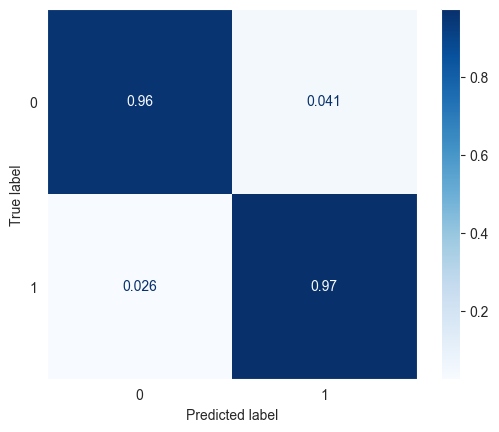

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [35]:
accuracy_score(true_labels, pred_labels)

0.9630892678034102

In [36]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

0.9592377863464113
0.9744861800141743
0.9668018625235983


# Feature visualization

In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned_reverse", return_tensor="pt")
model = AutoModel.from_pretrained("../models/bert_finetuned_reverse")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [38]:
def extract_hidden_states(batch):
    sentences = [x for x in batch["modified"]]
    with torch.no_grad():
        inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
        last_hidden_state = model(inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [ ]:
hidden = tokenized_data_split.map(
    extract_hidden_states, batched=True)

Map:   0%|          | 0/39880 [00:00<?, ? examples/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [ ]:
hidden.save_to_disk('../models/bert_dataset_reverse')

In [ ]:
hidden["test"].column_names

In [ ]:
print(np.array(hidden["train"]["hidden state"]).shape)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

X_train = np.array(hidden["train"]["hidden state"])
y_train = np.array(hidden["train"]["label"])

X_test = np.array(hidden["test"]["hidden state"])
y_test = np.array(hidden["test"]["label"])

In [ ]:
# reduce to 2d for visualization
pca = PCA(n_components=2)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_2d = pca.fit_transform(x_scaled)
x_2d.shape

x_scaled1 = MinMaxScaler().fit_transform(X_test)
x_2d1 = pca.fit_transform(x_scaled1)
x_2d1.shape

In [ ]:
# reduce to 3d for visualization
pca = PCA(n_components=3)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_3d = pca.fit_transform(x_scaled)
x_3d.shape

x_scaled1 = MinMaxScaler().fit_transform(X_test)
x_3d1 = pca.fit_transform(x_scaled1)
x_3d1.shape

In [ ]:
# 2d viz
fig, ax = plt.subplots(2, 2, figsize=(7, 5))
ax = ax.flatten()
cmaps = ["blue", "orange"]
labels = set([x.item() for x in tokenized_data_split["train"]["label"]])

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub = x_2d[y_train == i]
    ax[i].scatter(x_2d_sub[:, 0], x_2d_sub[:, 1], color=cmap)
    ax[i].set_title(id2label[label] +" TRAIN")
    
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub1 = x_2d1[y_test == i]
    ax[i+2].scatter(x_2d_sub1[:, 0], x_2d_sub1[:, 1], color=cmap)
    ax[i+2].set_title(id2label[label] +" TEST" )

plt.tight_layout()
plt.show()

### Shows us that there might be an overlap in control text and broca text which indistinguishable to the model (so model goes with control as sort of default strategy)

In [ ]:
# 3d vis

fig, ax = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(8, 6))
ax = ax.flatten()
cmaps = ["blue", "orange"]
labels = set([x.item() for x in tokenized_data_split["train"]["label"]])

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_3d_sub = x_3d[y_train == i]
    ax[i].scatter(x_3d_sub[:, 0], x_3d_sub[:, 1], color=cmap)
    ax[i].set_title(id2label[label]+" TRAIN")
    
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_3d_sub1 = x_3d1[y_test == i]
    ax[i+2].scatter(x_3d_sub1[:, 0], x_3d_sub1[:, 1], color=cmap)
    ax[i+2].set_title(id2label[label]+" TEST" )

plt.tight_layout()
plt.show()

# Attention viz

In [ ]:
from bertviz import model_view, head_view
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned", return_tensor="pt")
model = AutoModel.from_pretrained("../models/bert_finetuned")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### For control sentence

In [ ]:
input = tokenizer.encode(sentences[0], return_tensors="pt")
output = model(input, output_attentions=True)

attention = output[-1]
tokens = tokenizer.convert_ids_to_tokens(input[0]) 
model_view(attention, tokens)
print(sentences[0], true_labels[0])

### For broca sentence

In [ ]:
input = tokenizer.encode(sentences[8], return_tensors="pt")
output = model(input, output_attentions=True)

attention = output[-1]
tokens = tokenizer.convert_ids_to_tokens(input[0]) 
model_view(attention, tokens)
print(sentences[8], true_labels[8])